In [1]:
# load data
import random
from law import ScalingLaw
import matplotlib.pyplot as plt
from collections import defaultdict
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

from functools import partial


DOMAINS_2_SUBDOMAINS = {
    "academic": ["ArXiv", "PubMed_Abstracts", "PhilPapers", "NIH_ExPorter", "FreeLaw", "USPTO_Backgrounds", "PubMed_Central"],
    "prose": ["PG19", "Books3", "BookCorpus2"],
    "dialogue": ["Ubuntu_IRC", "OpenSubtitles", "EuroParl", "Enron_Emails", "HackerNews", "YoutubeSubtitles"],
    "symbolic": ["DM_Mathematics", "Github"],
    "internet": ["Pile-CC", "OpenWebText2", "StackExchange", "Wikipedia_en"],
}
SUBDOMAINS_2_DOMAINS = {
    subdomain: domain
    for domain, subdomains in DOMAINS_2_SUBDOMAINS.items() for subdomain in subdomains
}
with open("valid_weight.json", "r") as f:
    valid_weight = json.load(f)
for domain, subdomains in DOMAINS_2_SUBDOMAINS.items():
    valid_weight[domain] = sum(valid_weight[subdomain] for subdomain in subdomains)


def load_loss(path, filter=True):
    losses = defaultdict(lambda: defaultdict(dict))   # domain -> ratio
    with open(path, "r") as f:
        lines = set(f.readlines())
    for line in lines:   
        model, data, loss = line.split()
        model = model.strip('/')
        step = int(model.split('/')[-1])
        if filter and int(model.split('/')[-2].split('-')[0].split('_')[-1]) > 900:
            continue
        ratio = "-".join(model.split('/')[-2].split('-')[1:])
        subdomain = data.split('/')[-1].split('.')[-2]
        losses[ratio][subdomain][step] = float(loss)
    # merge
    for domain, subdomains in DOMAINS_2_SUBDOMAINS.items():
        domain_norm = sum(valid_weight[subdomain] for subdomain in subdomains)
        for ratio in losses:
            for step in losses[ratio][subdomains[0]]:
                try:
                    losses[ratio][domain][step] = sum(losses[ratio][subdomain][step] * valid_weight[subdomain] / domain_norm for subdomain in subdomains)
                except:
                    continue
    return losses

OBSERVED_LOSSES = {
    "70M": load_loss(f"data/5Mix/70M.txt"),
    "160M": load_loss(f"data/5Mix/160M.txt"),
    "305M": load_loss(f"data/5Mix/305M.txt"),
    "410M": load_loss(f"data/5Mix/410M.txt")
}   # sz, ratio, domain, step

seed=4096
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

MODEL_SZIE = "70M"
STEP = 30000
with open("data/5Mix/proportions.txt", "r") as f:
    ratios = list(OBSERVED_LOSSES[MODEL_SZIE]) # [line.strip() for line in f]
np.random.shuffle(ratios)
eval_ratios = ratios[20:]
train_ratios = ratios[:20]


x = np.array([list(map(float, ratio.split('-'))) for ratio in train_ratios])
y = np.array([
    sum(OBSERVED_LOSSES[MODEL_SZIE][ratio][domain][STEP] * valid_weight[domain] for domain in DOMAINS_2_SUBDOMAINS) 
    for ratio in train_ratios
])

In [5]:
# fit with mixture law
class ScalingLawWrap:
    def __init__(self, func):
        self.func = func
    
    def __call__(self, x, param):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        if not isinstance(param, torch.Tensor):
            param = torch.tensor(param, dtype=torch.float)
        return self.func(x, param)

def mixture_law_(x, param):
    log_c, log_k, t = param[0], param[1], param[2:]
    return torch.exp(log_c) + torch.exp(log_k + torch.matmul(x, t))

mixture_law = ScalingLawWrap(mixture_law_)

def param_genertor(idx):
    for log_c in np.linspace(-2, 1.5, 10):
        for logk in np.linspace(-10, 1, 20):
            for _ in range(30):
                ts = [-np.random.rand() if i == idx else np.random.rand() * 0.1 for i in range(5)]
                yield [log_c, logk] + ts

# linear by domains
linear_domain_params = {}
for domain in DOMAINS_2_SUBDOMAINS:
    x = np.array([list(map(float, ratio.split('-'))) for ratio in ratios])
    y = np.array([
        OBSERVED_LOSSES[MODEL_SZIE][ratio][domain][STEP]
        for ratio in ratios
    ])
    law = ScalingLaw(mixture_law)
    linear_domain_params[domain] = law.fit(x, y, param_genertor(-1), max_step=50, eps=0, valid_split=0, delta=0.05)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:31<00:00, 187.90it/s]


0.0005682876217179
tensor([  0.9750,  -2.1391, -10.0864,   2.7140,   2.7106,   2.6083,   1.5866])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:31<00:00, 191.58it/s]


0.00012334295024629682
tensor([ 1.2624, -2.1656,  1.3930, -4.6811,  0.7855,  1.8719,  0.5734])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:27<00:00, 214.92it/s]


0.0005513424403034151
tensor([  1.1375,  -7.1017,   6.7135,   6.2643, -31.8621,   6.6423,   6.2053])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:35<00:00, 166.99it/s]


0.0001428198884241283
tensor([  0.4750,  -3.6546,   3.3289,   3.6705,   3.1127, -16.4217,   3.1591])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:31<00:00, 192.01it/s]


8.165960753103718e-05
tensor([ 1.2402, -1.9510,  1.1897,  0.8697, -0.5184,  1.7122, -3.0870])


In [3]:
# fit with mlp
from sklearn.ensemble import AdaBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin

class MixtureMLP(nn.Module):
    def __init__(self, dim=10, num_mixture=5, activation="exp", bias=None) -> None:
        super().__init__()
        self.in_linear = nn.Linear(num_mixture, dim)
        # for i in range(self.in_linear.weight.data.shape[0]):
        #     self.in_linear.weight.data[i, i%num_mixture] = -10 * np.abs(self.in_linear.weight.data[i, i%num_mixture]) 
        self.out_linear = nn.Linear(dim, 1)
        self.act = activation
        if bias is not None:
            self.out_linear.bias = nn.Parameter(torch.tensor([bias], dtype=torch.float))
        # self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float)
        h = self.in_linear(x)
        if self.act == "exp":
            h = torch.exp(h)
        elif self.act == "relu":
            h = torch.nn.functional.relu(h)
        elif self.act == "gelu":
            h = torch.nn.functional.gelu(h, approximate="tanh")
        elif self.act == "silu":
            h = torch.nn.functional.silu(h)
        elif self.act == "tanh":
            h = torch.nn.functional.tanh(h)
        elif self.act == "sigmoid":
            h = torch.nn.functional.sigmoid(h)
        elif self.act == "softplus":
            h = torch.nn.functional.softplus(h)
        # return self.out_linear(torch.nn.functional.gelu(self.in_linear(x)))
        w = F.softmax(self.out_linear.weight, dim=-1)
        # import ipdb;ipdb.set_trace()
        return torch.matmul(h, w.T) + self.out_linear.bias


class MLPEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, dim, num_mixture, activation):
        # Initialize parameters
        self.dim, self.num_mixture, self.activation = dim, num_mixture, activation
        self.mlp = MixtureMLP(dim, num_mixture, activation)
        self.use_cuda = torch.cuda.is_available()

    def fit(self, X, y):
        best_valid_loss, valid_split = 1e10, int(X.shape[0] / 5)
        X, y = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)
        optimizer = torch.optim.AdamW(self.mlp.parameters(), lr=0.1, weight_decay=1e-3)
        for _ in range(5000):
            self.mlp.train()
            # loss = optimizer.step(closure)
            loss = torch.nn.functional.huber_loss(self.mlp(torch.tensor(X[:-valid_split]).float()).squeeze(), torch.tensor(y[:-valid_split]).float(), delta=0.05)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                self.mlp.eval()
                valid_loss = torch.nn.functional.l1_loss(self.mlp(torch.tensor(X).float()).squeeze(), torch.tensor(y).float())
                # valid_loss = torch.nn.functional.mse_loss(mlp(torch.tensor(x[-5:]).float()).squeeze(), torch.tensor(y[-5:]).float())
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_param = self.mlp.state_dict()
        self.mlp.load_state_dict(best_param)

    @torch.no_grad()
    def predict(self, X):
        if self.use_cuda:
            self.mlp.eval()
            self.mlp = self.mlp.cuda()
            x = torch.tensor(X, dtype=torch.float, device='cuda')
            result = self.mlp(x).squeeze().cpu().numpy()
            self.mlp = self.mlp.cpu()
        else:
            x = torch.tensor(X, dtype=torch.float)
            result = self.mlp(x).squeeze().numpy()
        return result

# mlp for all
mlp_boost_params, mlp_params = {}, {}
x = np.array([list(map(float, ratio.split('-'))) for ratio in ratios])
y = np.array([
    sum(OBSERVED_LOSSES[MODEL_SZIE][ratio][domain][STEP] * valid_weight[domain] for domain in DOMAINS_2_SUBDOMAINS) 
    for ratio in ratios
])
# for dim in [1, 2, 3, 5, 10, 20, 30]:
#     best_valid_loss, best_param = 1e10, None
#     for i in range(5):
#         regr = AdaBoostRegressor(MLPEstimator(dim, 5, "exp"), random_state=i, n_estimators=10)
#         regr.fit(x, y)
#         prediction = regr.predict(x)
#         err = np.mean(np.abs(prediction - y))
#         if err < best_valid_loss:
#             best_valid_loss = err
#             best_param = regr
#     mlp_boost_params[dim] = best_param
    
#     best_valid_loss, best_param = 1e10, None 
#     for retry in tqdm(range(10)):
#         mlp = MixtureMLP(dim=dim)
#         optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-1, weight_decay=1e-3)
#         for _ in range(10000):
#             mlp.train()
#             loss = torch.nn.functional.mse_loss(mlp(torch.tensor(x).float()).squeeze(), torch.tensor(y).float()) # , delta=0.1)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             with torch.no_grad():
#                 mlp.eval()
#                 valid_loss = torch.nn.functional.mse_loss(mlp(torch.tensor(x[-5:]).float()).squeeze(), torch.tensor(y[-5:]).float())
#             if valid_loss + loss < best_valid_loss:
#                 best_valid_loss = valid_loss
#                 best_param = mlp.state_dict()
#                 best_step = _
#     mlp_params[dim] = best_param

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.73s/it]


0.008618404835830503
0.026849099638040164
0.010382906399636497
0.00267916500813666
0.002400890789895286
0.0019938940864530816


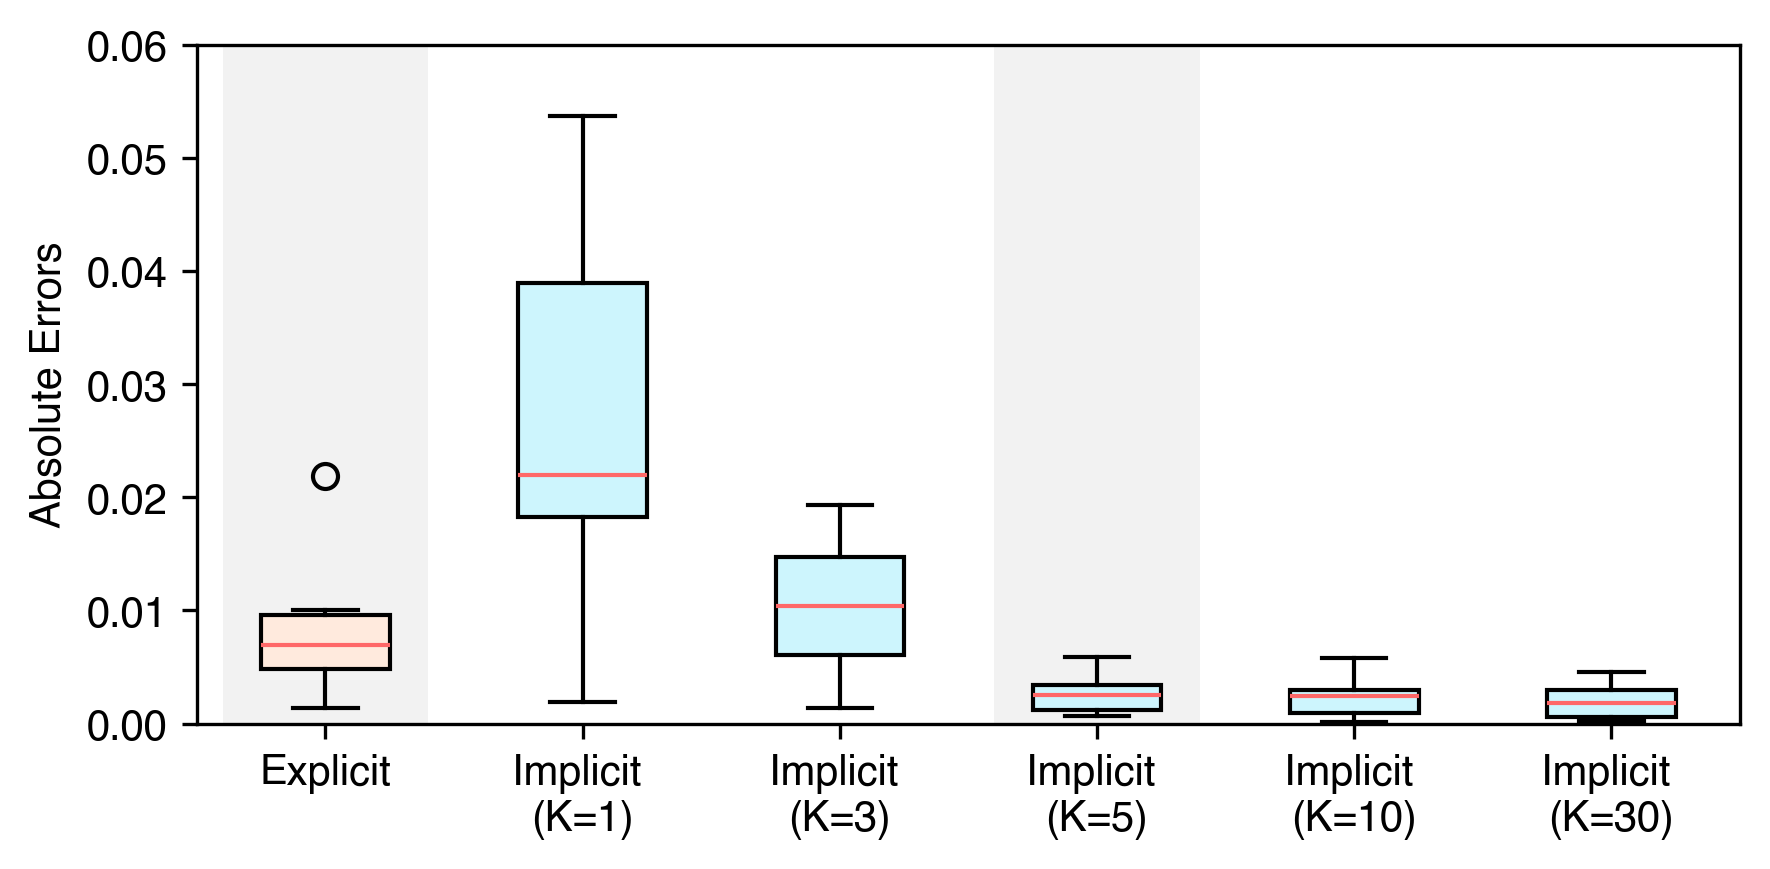

In [9]:
# calculate the errors
# fig
x = np.array([list(map(float, ratio.split('-'))) for ratio in eval_ratios]) # ratios])
y = np.array([
    sum(OBSERVED_LOSSES[MODEL_SZIE][ratio][domain][STEP] * valid_weight[domain] for domain in DOMAINS_2_SUBDOMAINS) 
    for ratio in eval_ratios# ratios
])
errors = []

linear_domain_prediction = sum(mixture_law(x, linear_domain_params[domain]).numpy() * valid_weight[domain] for domain in DOMAINS_2_SUBDOMAINS)
errors.append(np.abs(y - linear_domain_prediction))
mlp_params = torch.load("data/5Mix/mix5mlp.pt")
for dim in [1,3,5,10,30]:
    state_dict = mlp_params[dim]
    mlp = MixtureMLP(dim=dim)
    mlp.load_state_dict(state_dict)
    mlp.eval()
    with torch.no_grad():
        mlp_prediction = mlp(torch.tensor(x)).squeeze().numpy()
    errors.append(np.abs(y - mlp_prediction))
fig = plt.figure(figsize=(6, 3), dpi=300)
bp = plt.boxplot(
    errors, labels=["Explicit", "Implicit \n(K=1)", "Implicit \n(K=3)", "Implicit \n(K=5)", "Implicit \n(K=10)", "Implicit \n(K=30)"],
    patch_artist=True
)
colors = ['#FFEADD'] + ["#CDF5FD"]*5 # '#F3F8FF', '#F3F8FF', '#F3F8FF', '#F3F8FF', '#F3F8FF', '#F3F8FF']  # Blue, Green, Red
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color('#FF6868')  # Set the color of the median lines to red

plt.ylim(0, 0.06)
# plt.cla()
# plt.violinplot(errors)
# plt.xticks(range(len(errors)), ["ALL Lin", "ALL Dom", "1", "3", "5", "10", "20", "30"])
# plt.savefig("mixture_violon_20.png")
# plt.ylim(0, 0.05)
plt.axvspan(0.6, 1.4, color='gray', alpha=0.1, linewidth=0)  # For 'Separate'
plt.axvspan(3.6, 4.4, color='gray', alpha=0.1, linewidth=0) 
for error in errors:
    print(np.mean(error))
plt.ylabel("Absolute Errors")
plt.tight_layout()
plt.savefig("savefigs/5mix_end2end.png")


In [10]:
len(eval_ratios)

6

In [5]:
mlp_params2 = mlp_params